# Batch GP Regression

## Introduction

In this notebook, we demonstrate how to train Gaussian processes in the batch setting -- that is, given `b` training sets and `b` separate test sets, GPyTorch is capable of training independent GPs on each training set and then testing each GP separately on each test set in parallel. This can be extremely useful if, for example, you would like to do k-fold cross validation.

**Note:** When operating in batch mode, we do **NOT** account for any correlations between the different functions being modeled. If you wish to do this, see the multitask examples instead.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from torch import optim
from gpytorch.kernels import RBFKernel, MaternKernel
from gpytorch.means import ConstantMean
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

## Set up training data

In the next cell, we set up the training data for this example. For the x values, we'll be using 11 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. For the training labels, we'll be modeling four functions independently in batch mode: two sine functions with different periods and two cosine functions with different periods. 

In total, `train_x` will be `4 x 100 x 1` (`b x n x 1`) and `train_y` will be `4 x 100` (`b x n`)

In [3]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100).view(1, -1, 1).repeat(4, 1, 1)
# True function is sin(2*pi*x) with Gaussian noise
sin_y = torch.sin(train_x[0].data * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
sin_y_short = torch.sin(train_x[0].data * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y = torch.cos(train_x[0].data * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y_short = torch.cos(train_x[0].data * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
train_y = torch.cat((sin_y, sin_y_short, cos_y, cos_y_short)).squeeze(-1)

## Setting up the model

The next cell adapts the model from the Simple GP regression tutorial to the batch setting. Not much changes: the only modification is that we add a `batch_size` to the mean and covariance modules. What this does internally is replicates the mean constant and lengthscales `b` times so that we learn a different value for each function in the batch.

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_size=4)
        self.covar_module = MaternKernel(batch_size=4)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood()
model = ExactGPModel(train_x.data, train_y.data, likelihood)

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process. This loop is nearly identical to the simple GP regression setting with one key difference. Now, the call through the mariginal log likelihood returns `b` losses, one for each GP. Since we have different parameters for each GP, we can simply sum these losses before calling `backward`.

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

/home/jrg365/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter 1/50 - Loss: 4.603   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 3.833   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/50 - Loss: 3.060   log_lengthscale: -0.200   log_noise: -0.200
Iter 4/50 - Loss: 2.290   log_lengthscale: -0.299   log_noise: -0.300
Iter 5/50 - Loss: 1.524   log_lengthscale: -0.399   log_noise: -0.400
Iter 6/50 - Loss: 0.758   log_lengthscale: -0.499   log_noise: -0.500
Iter 7/50 - Loss: -0.003   log_lengthscale: -0.599   log_noise: -0.600
Iter 8/50 - Loss: -0.757   log_lengthscale: -0.701   log_noise: -0.701
Iter 9/50 - Loss: -1.503   log_lengthscale: -0.802   log_noise: -0.801
Iter 10/50 - Loss: -2.252   log_lengthscale: -0.898   log_noise: -0.901
Iter 11/50 - Loss: -3.008   log_lengthscale: -0.987   log_noise: -1.001
Iter 12/50 - Loss: -3.741   log_lengthscale: -1.073   log_noise: -1.102
Iter 13/50 - Loss: -4.493   log_lengthscale: -1.147   log_noise: -1.202
Iter 14/50 - Loss: -5.241   log_lengthscale: -1.210   log_noise: -1.302
Iter 15/5

## Make predictions with the model

Making predictions with batched GPs is straight forward: we simply call the model (and optionally the likelihood) on batch `b x t x 1` test data. The resulting `GaussianRandomVariable` will have a `b x n` mean and a `b x n x n` covariance matrix. Standard calls like `preds.confidence_region()` still function -- for example `preds.var()` returns a `b x n` set of predictive variances.

In the cell below, we make predictions in batch mode for the four functions and plot the GP fit for each one.

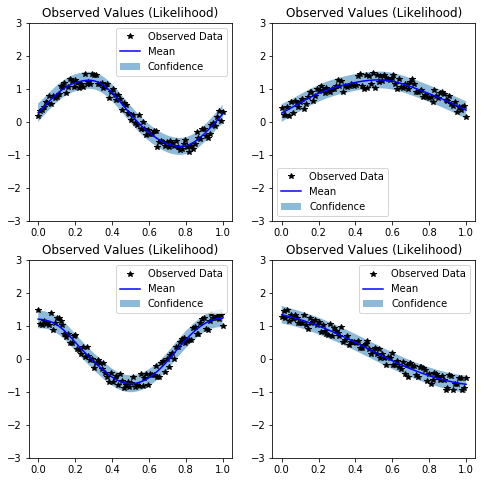

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(8, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(4, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].numpy(), upper[0, :].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].numpy(), upper[1, :].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y3_ax.plot(train_x[2].detach().numpy(), train_y[2].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y3_ax.plot(test_x[2].squeeze().numpy(), mean[2, :].numpy(), 'b')
    # Shade in confidence 
    y3_ax.fill_between(test_x[2].squeeze().numpy(), lower[2, :].numpy(), upper[2, :].numpy(), alpha=0.5)
    y3_ax.set_ylim([-3, 3])
    y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y3_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y4_ax.plot(train_x[3].detach().numpy(), train_y[3].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y4_ax.plot(test_x[3].squeeze().numpy(), mean[3, :].numpy(), 'b')
    # Shade in confidence 
    y4_ax.fill_between(test_x[3].squeeze().numpy(), lower[3, :].numpy(), upper[3, :].numpy(), alpha=0.5)
    y4_ax.set_ylim([-3, 3])
    y4_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y4_ax.set_title('Observed Values (Likelihood)')
    

# Plot both tasks
ax_plot()